<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
# !nvidia-smi

In [89]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Confusion matrix imports
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Import helpers
from helper_functions import *

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

# TODO: Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

PyTorch version: 2.0.1
torchvision version: 0.15.2


'mps'

## 1. What are 3 areas in industry where computer vision is currently being used?

- Autonomous Vehicles
- Drone localisation
- Face recognition

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

Overfitting is a phenomenon in machine learning, where the model learns the training set well, but is unable to generalize to the test data. It is common when using a model that capacity is significantly larger than necessery, than the traind model variance is to high and the model learns the noise in data instead of the patterns.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

- **Regularization**:  While optimizing our model, we would also like to reward the simpler models. There are different ways of such regularization, such as L1 or L2 cost which constraints the parameters.
- **Ensamble learning**: We can benefit from training a bunch of models, and take their average as a result. In this way the variance may be reduced. A very clever way to implement ensamblelearning in neural networks is a *Dropout*, which "simulates" multiple models by the use of stochastic properties.
- **Early Stopping**: An overvitting can easily be spotted when the learning curves (training and testing) diverges. We can monitor their dynamics, and act on the event of testing curve not following along the training one

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [90]:
# Setup training data
train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    download=True # download data if it doesn't exist on disk
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    transform=ToTensor(),
    download=True
)

# Class names
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 6. Visualize at least 5 different samples of the MNIST training dataset.

torch.Size([60000, 28, 28]) torch.Size([60000])


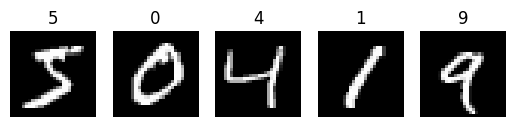

In [4]:
print(train_data.data.shape, train_data.targets.shape)

# Visualise 5 samples of training data
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(train_data.data[i], cmap="gray")
    ax[i].set_title(train_data.targets[i].item())
    ax[i].axis("off")
plt.show()


## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [33]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=True # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x149d79a20>, <torch.utils.data.dataloader.DataLoader object at 0x149d79270>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [6]:
# Create a convolutional neural network 
class MNISTModelTinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = MNISTModelTinyVGG(input_shape=1, 
    hidden_units=10, 
    output_shape=10).to(device)
model_2

MNISTModelTinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [79]:
from tqdm.auto import tqdm

/Users/wciezobka/venvs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Get first item from train_dataloader
for images, labels in train_dataloader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Images shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])


In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

### With CPU

In [11]:
# device = "cpu"

In [12]:
# torch.manual_seed(44)

# # Measure time
# from timeit import default_timer as timer
# start_time = timer()

# # Train and test model 
# epochs = 5
# for epoch in tqdm.tqdm(range(epochs)):
#     print(f"Epoch: {epoch}\n---------")
#     train_step(data_loader=train_dataloader, 
#         model=model_2, 
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         accuracy_fn=accuracy_fn,
#         device=device
#     )
#     test_step(data_loader=test_dataloader,
#         model=model_2,
#         loss_fn=loss_fn,
#         accuracy_fn=accuracy_fn,
#         device=device
#     )

# end_time = timer()
# cpu_train_time = print_train_time(start=start_time,
#                                            end=end_time,
#                                            device=device)

### With MPS

In [13]:
device = "mps"

In [14]:
torch.manual_seed(44)

# Measure time
from timeit import default_timer as timer
start_time = timer()

# Train and test model 
epochs = 5
for epoch in tqdm.tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

end_time = timer()
mps_train_time = print_train_time(start=start_time,
                                           end=end_time,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.31530 | Train accuracy: 89.21%


 20%|██        | 1/5 [00:09<00:38,  9.62s/it]

Test loss: 0.07139 | Test accuracy: 97.59%

Epoch: 1
---------
Train loss: 0.07434 | Train accuracy: 97.72%


 40%|████      | 2/5 [00:19<00:28,  9.62s/it]

Test loss: 0.05718 | Test accuracy: 98.08%

Epoch: 2
---------
Train loss: 0.05803 | Train accuracy: 98.20%


 60%|██████    | 3/5 [00:29<00:19,  9.99s/it]

Test loss: 0.05500 | Test accuracy: 97.99%

Epoch: 3
---------
Train loss: 0.04838 | Train accuracy: 98.52%


 80%|████████  | 4/5 [00:39<00:09,  9.86s/it]

Test loss: 0.04907 | Test accuracy: 98.38%

Epoch: 4
---------
Train loss: 0.04316 | Train accuracy: 98.64%


100%|██████████| 5/5 [00:48<00:00,  9.72s/it]

Test loss: 0.03800 | Test accuracy: 98.85%


Train time on mps: 48.605 seconds


### Time Comparison

Text(0, 0.5, 'Training time (seconds)')

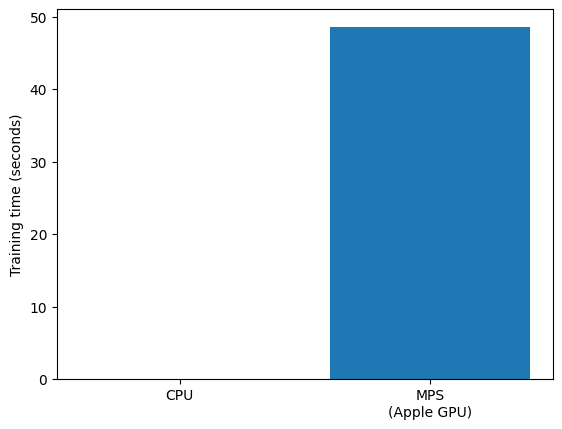

In [15]:
plt.bar(x=["CPU", "MPS\n(Apple GPU)"], height=[0, mps_train_time])
plt.ylabel("Training time (seconds)")

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

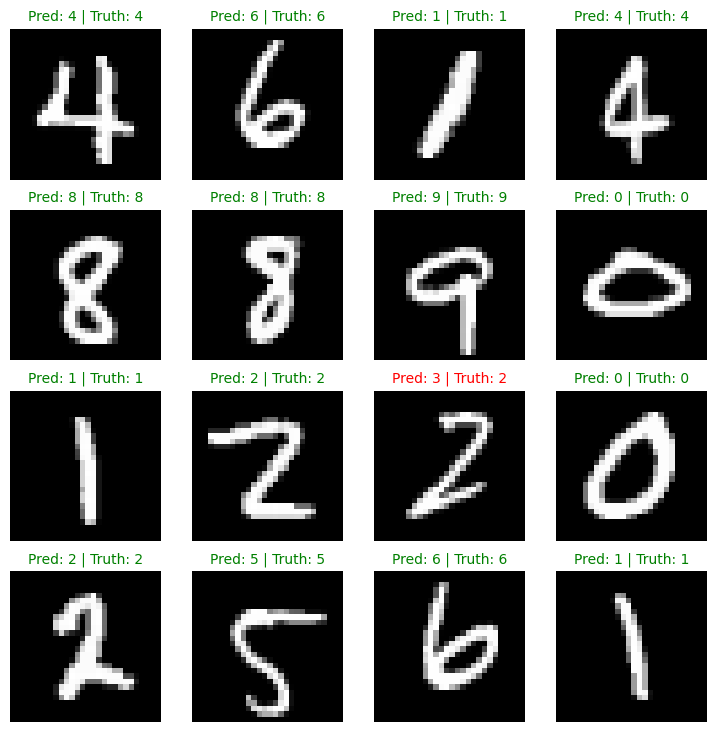

In [98]:
# Sample a batch
X, y = next(iter(test_dataloader))
with torch.inference_mode():
    y_preds = model_2(X.to(device)).argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 4
ncols = 4
for i, sample in enumerate(torch.reshape(X, (-1, 28, 28))):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = y_preds[i].item()

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = y[i].item()

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

    if i + 1 == 16:
        break

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [99]:
# 1. Make predictions with trained model
y_preds = []
y_golds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_golds.append(y.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_gold_tensor = torch.cat(y_golds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 346.66it/s]


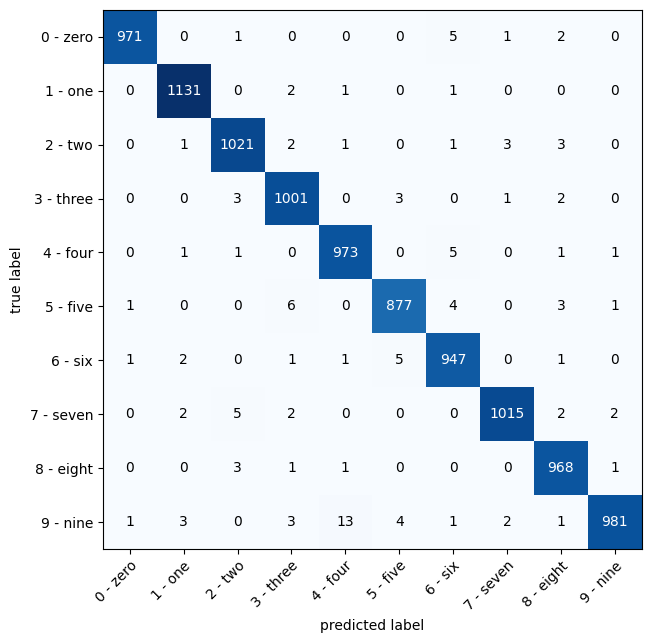

In [100]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_gold_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [118]:
random_tensor = torch.rand(1, 3, 64, 64)
nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)(random_tensor).shape

torch.Size([1, 3, 32, 32])

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

### Load FashionMNIST

In [126]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    download=True # download data if it doesn't exist on disk
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    transform=ToTensor(),
    download=True
)

# Class names
class_names = train_data.classes
class_names

100%|██████████| 26421880/26421880 [00:09<00:00, 2646701.39it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 906809.28it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2679646.20it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12035828.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [135]:
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x2a8815a20>, <torch.utils.data.dataloader.DataLoader object at 0x2a8819bd0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### Load trained Model (from the 03_notebook)

In [136]:
model_fashion = MNISTModelTinyVGG(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
MODEL_SAVE_PATH = "/Users/wciezobka/projects/pytorch-deep-learning/models/03_pytorch_computer_vision_model_2.pth"
model_fashion.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
model_fashion = model_fashion.to(device)

### Make predictions

In [142]:
# 1. Make predictions with trained model
y_preds = []
y_golds = []
model_fashion.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_fashion(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_golds.append(y.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_gold_tensor = torch.cat(y_golds)

# Calculate accuracy
accuracy_score = (y_pred_tensor == y_gold_tensor).sum() / len(y_pred_tensor)
print(f"Accuracy score: {accuracy_score:.5f}")

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 351.89it/s]

Accuracy score: 0.89120


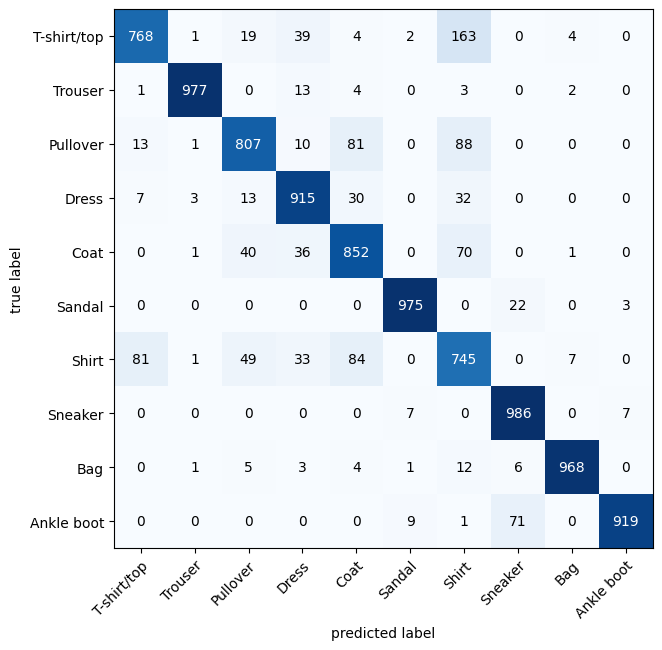

In [162]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_gold_tensor)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

### Visualise mistakes

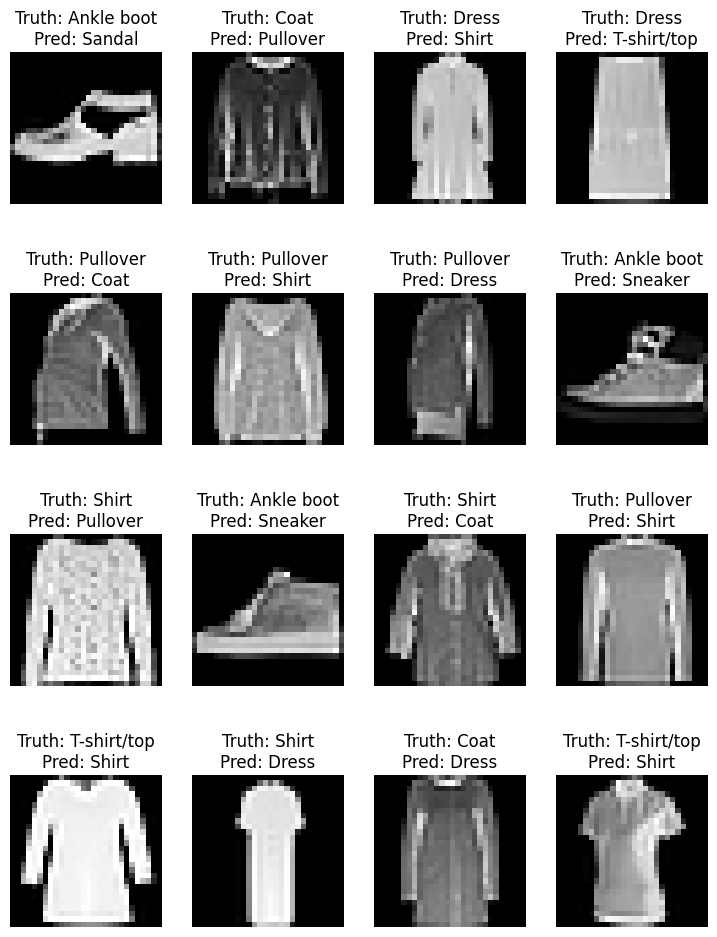

In [163]:
mistakes_mask = y_pred_tensor != y_gold_tensor
mistakes_indices = torch.where(mistakes_mask)[0]

# Extract mistaken examples from test dataset
mistaken_examples = torch.utils.data.Subset(test_data, indices=mistakes_indices)
mistaken_targets = torch.utils.data.Subset(test_data, indices=mistakes_indices)
predicted_targets = y_pred_tensor[mistakes_indices]

# Visualise 5 samples of mistaken examples
plt.figure(figsize=(9, 12))
nrows = 4
ncols = 4
for i in range(16):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(mistaken_examples[i][0].squeeze(), cmap="gray")
    plt.title(f"Truth: {class_names[mistaken_targets[i][1]]}\nPred: {class_names[predicted_targets[i]]}")
    plt.axis("off")
plt.show()

### Conclusion
By looking at the mistakes, it seems that the model is doing a good job, and the mistakes are due to the data. The labels are too close to each other, and the model is not able to distinguish between them. For example, the model is not able to distinguish between a shirt and a t-shirt, or a pullover and a coat. The model is also not able to distinguish between a sandal and a sneaker.